In [1]:
import os
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
os.chdir("..")
PATH = os.getcwd()

In [3]:
!ls

data		 Jenkinsfile  notebooks   reports	       tox.ini
Dockerfile	 LICENSE      OFL.txt	  src
docs		 Makefile     README.md   start.sh
environment.yml  models       references  test_environment.py


## Import Data

In [4]:
from src.data.obtain import get_raw_data
df = get_raw_data()

# Scrub Data

In [5]:
print("Declaring an empty dictionary to persist information we'll need to scrub new data in production.")
dict_persist = {}

Declaring an empty dictionary to persist information we'll need to scrub new data in production.


### Column Names

In [6]:
print("Fixing column names. (Removing special characters, converting to lowercase. Renaming long columns)")
df.columns = map(lambda i: i.lower().translate(None, './()& '), 
                 df.columns.tolist())

df.rename(columns={'siblingsspousesaboard': 'sibsp'}, inplace=True)

Fixing column names. (Removing special characters, converting to lowercase. Renaming long columns)


### Missings

In [7]:
have_missing = \
(df
 .isnull()
 .sum()
 .where(lambda x: x > 0)
 .dropna()
 .index
 .tolist()
)

print("The following columns have missing data: \n{}".format(have_missing))

The following columns have missing data: 
['age', 'fare', 'cabinnumber', 'embarked']


In [8]:
#
dict_persist['have_missing'] = have_missing
#

In [9]:
pd.DataFrame({
    'type': df[have_missing].dtypes,
    'perc_missing': df[have_missing].isnull().mean().round(2),
    'num_missing': df[have_missing].isnull().sum()
})

,num_missing,perc_missing,type
age,263,0.20,float64
fare,1,0.00,float64
cabinnumber,1014,0.77,object
embarked,2,0.00,object


In [10]:
for COL in have_missing:
    """
    Create a missing flag for each column
    that has missing data.
    """
    newCOL = COL + '__is_null'
    df.loc[:, newCOL] = df.loc[:, COL].isnull().astype(int)

''

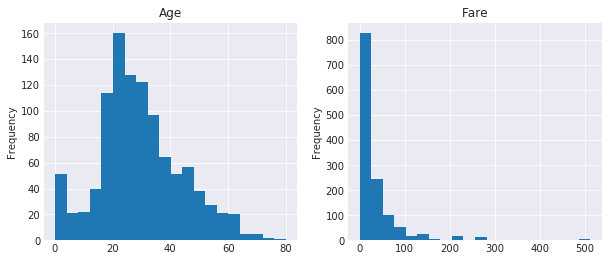

In [11]:
# impute missings
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

df['age'].plot.hist(bins=20, ax=ax[0], title='Age')
df['fare'].plot.hist(bins=20, ax=ax[1], title='Fare')
;

In [12]:
print("Age is approximately normally distributed, but Fare is skewed.")
print("Using the mean for Age and Median for Fare to impute missing data.")
print("Cabin Number has over 70% values missing. Dropping this variable.")
print("Embarked has only 2 values missing. Imputing with Mode.")

age_fillna = df['age'].mean()
fare_fillna = df['fare'].median()
embarked_fillna = df['embarked'].describe()['top']

df['age'].fillna(value=age_fillna, inplace=True)
df['fare'].fillna(value=fare_fillna, inplace=True)
df['embarked'].fillna(value=embarked_fillna, inplace=True)

Age is approximately normally distributed, but Fare is skewed.
Using the mean for Age and Median for Fare to impute missing data.
Cabin Number has over 70% values missing. Dropping this variable.
Embarked has only 2 values missing. Imputing with Mode.


In [13]:
#
dict_persist['age_fillna'] = age_fillna
dict_persist['fare_fillna'] = fare_fillna
dict_persist['embarked_fillna'] = embarked_fillna
#

### Create new columns

In [14]:
print("Creating a column for Gender")

df.loc[:, 'gender'] = df['name'].map(lambda i: 1 if 'Miss' in i or 'Mrs' in i else 0)

Creating a column for Gender


In [15]:
print("Creating Dummies for Embarked and Passenger Class. \nDone. Now dropping these.")

df = df.join(pd.get_dummies(df['embarked'], prefix='embarked'))
df = df.join(pd.get_dummies(df['passengerclass'], prefix='pclass'))

df.drop(['embarked', 'passengerclass'], axis=1, inplace=True)

Creating Dummies for Embarked and Passenger Class. 
Done. Now dropping these.


### Remove Zero Variance Columns

In [16]:
perc_uniqs_catg = \
(df
 .describe(include=['O'])
 .T
 .assign(perc_uniq = lambda fr: fr['unique']/fr['count'])
 .loc[:, 'perc_uniq']
 .astype(float)
 .round(2)
)

perc_uniqs_catg

name           1.00
ticket         0.71
cabinnumber    0.63
Name: perc_uniq, dtype: float64

In [17]:
print("Dropping cabinnumber, ticket and name as they have no predictive value. (Too many uniques)")
df.drop(['cabinnumber', 'ticket', 'name'], axis=1, inplace=True)

Dropping cabinnumber, ticket and name as they have no predictive value. (Too many uniques)


### Convert to numeric

In [18]:
print("Downcasting numerics to occupy less space.")
df = df.apply(lambda c: pd.to_numeric(c, downcast='integer'))

Downcasting numerics to occupy less space.


## Backup

In [21]:
df.to_csv("data/04-processed/titanic.csv")

from src import scrub_params
import json 

with open(scrub_params, 'w') as fp:
    json.dump(dict_persist, fp)